In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
participants_ukb_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
covariates = ["Sex", "Age", "brain_volume"]
max_iter = 2000
cv = 3

In [3]:
participants = pd.read_csv(participants_file, index_col=0)


In [4]:
participants.head()

,brain_volume,isSynesthete,NOM,DDN,IRM name,Date IRM,Age,Sex,Lateralite,Remarques,Code BV,Unnamed: 9,0=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,1261229.989,0,PECL,12/8/1998,Control02,NaN,25.000000,1,0,Pas analysé,Sujet9,NaN,NaN,NaN
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,1229268.222,0,VIMA,18/3/1985,Control27,28/2/2023,37.975342,0,0,NaN,Sujet10,NaN,NaN,NaN
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1026066.763,1,SICA,17/8/1985,Sujet23,3/3/2023,37.567123,0,0,NaN,Sujet11,NaN,NaN,NaN
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1164323.992,1,HACL,10/6/1972,Sujet24,29/3/2023,50.832877,0,0,NaN,Sujet12,NaN,NaN,NaN
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1127962.029,1,HELI,2/11/1966,Sujet25,20/5/2023,56.583562,0,0,NaN,Sujet13,NaN,NaN,NaN


In [5]:
participants = participants[["isSynesthete", "brain_volume", "Age", "Sex"]]

In [6]:
participants[:] = participants.sample(frac=1).values

In [7]:
participants

,isSynesthete,brain_volume,Age,Sex
participant_id,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,1,1361438.908,33.408219,1
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,1,907384.340,39.940000,0
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,0,1270295.704,52.698630,1
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1,1164323.992,50.832877,0
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,0,1172362.958,46.739726,0
mv_SYNESTHEX_Sujet14_Session2_S12_T1w,0,925605.453,42.246575,0
mv_SYNESTHEX_Sujet15_Session2_S13_T1w,1,1289949.175,51.225000,1
mv_SYNESTHEX_Sujet16_Session1_S2_T1w,1,1781970.333,26.334247,1
mv_SYNESTHEX_Sujet17_session1_S2_T1w,1,1278306.108,41.712329,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'brain_volume'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>]],
      dtype=object)

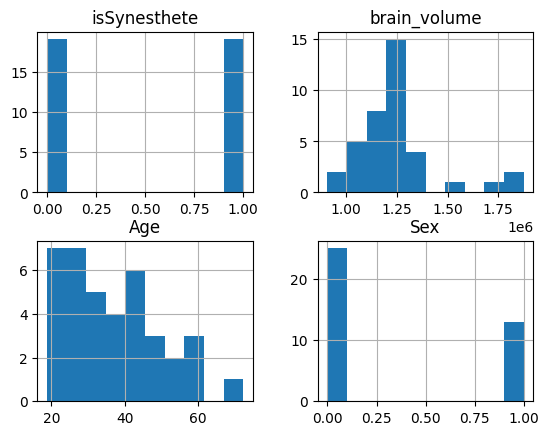

In [8]:
participants.hist()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'brain_volume'}>, <Axes: >]], dtype=object)

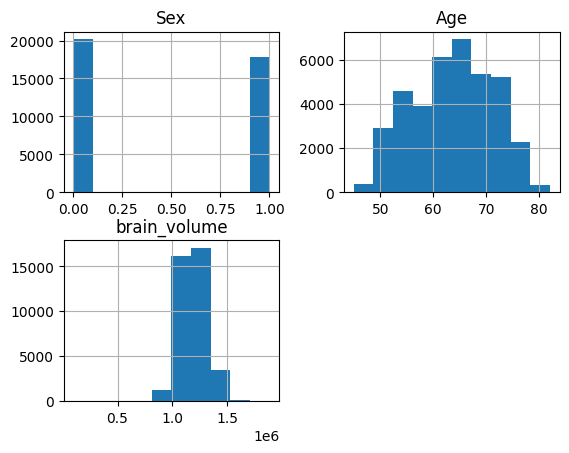

In [9]:
participants_ukb = pd.read_csv(participants_ukb_file, index_col=0)
participants_ukb = participants_ukb[["Sex", "Age", "BrainVolumeFreeSurfer_mm3"]].rename(columns={"BrainVolumeFreeSurfer_mm3": "brain_volume"})
participants_ukb.hist()

In [10]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [11]:
model_paths = get_model_paths(path_champollion)

In [12]:
models_df = pd.DataFrame({"path":model_paths})

In [13]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [14]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label] + covariates].merge(embeddings, left_index=True, right_index=True)

    # Residualizes using ukb embeddings
    embeddings_ukb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    phenotypes_cols = embeddings_ukb.columns # Supposes that phenotype names are identical
    merged_ukb = participants_ukb[covariates].merge(embeddings_ukb, left_index=True, right_index=True)
    
    resid_df = merged[[label]].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    resid_df_ukb = merged_ukb[covariates].copy()
    resid_df_ukb.loc[:, phenotypes_cols] = 0.0

    for dim_i in phenotypes_cols:
        X = merged_ukb[covariates]
        X = sm.add_constant(X)
        y = merged_ukb[dim_i]
        model = sm.OLS(y, X).fit()
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df_ukb.loc[:, dim_i] = residuals

        X = merged[covariates]
        X = sm.add_constant(X)
        y = merged[dim_i]
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df.loc[:, dim_i] = residuals

    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)

    # Makes PCA on UkBioBank residuals
    pca = PCA(n_components=3)
    pca.fit(resid_df_ukb.loc[:, phenotypes_cols])

    # Gets synesthete residuals
    X = resid_df.loc[:, phenotypes_cols]
    Y = resid_df[[label]]

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    predictions = results.predict(df2)

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value, p_value)
    
    # Returns result
    return (region, predictions, Y)

In [15]:
participants.dtypes

isSynesthete      int64
brain_volume    float64
Age             float64
Sex               int64
dtype: object

In [16]:
result = pd.DataFrame({})
for random_state in range(5):

    # Computes AUC
    for model_path in model_paths:
        ret = compute(model_path, random_state)
        f = ret[1].to_frame().T
        f.insert(0, "region", [ret[0]])
        result = pd.concat([result, f]).reset_index(drop=True)
        Y = ret[2]

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
0.7207157606202605 0.5465748932052583
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
0.6125658633923045 0.6115373066830767
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.5432090490942804 0.6560359364005507
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.461324452147819 0.24238982717543278
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.045786215712184636 0.9867677171635774
Treating S.T.s.-S.GSM._left: STs-SGSM_left

In [17]:
result

,region,mv_SYNESTHEX_Sujet09_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet11_Session2_S14_T1w,mv_SYNESTHEX_Sujet12_Session2_S12_T1w,mv_SYNESTHEX_Sujet13_Session2_S13_T1w,mv_SYNESTHEX_Sujet14_Session2_S12_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w,mv_SYNESTHEX_Sujet16_Session1_S2_T1w,mv_SYNESTHEX_Sujet17_session1_S2_T1w,...,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet22_Session1_S2_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_Sujet26_Session1_S2_T1w,mv_SYNESTHEX_Sujet27_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w
0,S.C.-sylv._left,0.474912,0.561044,0.411235,0.439831,0.324027,0.255823,0.364128,0.567595,0.669718,...,0.645330,0.506154,0.597745,0.498438,0.590428,0.137920,0.576609,0.510309,0.571288,0.575035
1,S.C.-sylv._left,0.520737,0.507332,0.390847,0.556178,0.344189,0.327372,0.366882,0.643760,0.625156,...,0.608370,0.477267,0.412011,0.589418,0.571739,0.130399,0.567005,0.542986,0.518417,0.544991
2,S.F.inter.-S.F.sup._left,0.560337,0.412606,0.510734,0.532038,0.511113,0.349937,0.407972,0.577337,0.610874,...,0.608435,0.739888,0.341166,0.369231,0.577523,0.497327,0.548819,0.672964,0.473909,0.462143
3,S.T.i.-S.T.s.-S.T.pol._right,0.562328,0.373846,0.527152,0.749110,0.517514,0.270358,0.390042,0.541503,0.804752,...,0.413441,0.537999,0.497789,0.416093,0.400025,0.175688,0.559246,0.739417,0.782733,0.488714
4,F.Coll.-S.Rh._right,0.479030,0.546326,0.486883,0.462403,0.474381,0.518339,0.523042,0.464419,0.500083,...,0.538080,0.498797,0.500981,0.488281,0.527140,0.516538,0.442639,0.483106,0.440850,0.490483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,S.C.-S.Po.C._left,0.603778,0.542096,0.441399,0.604590,0.317016,0.284923,0.328974,0.652395,0.651221,...,0.586724,0.507424,0.511215,0.646642,0.479210,0.169633,0.616451,0.480142,0.506265,0.585640
486,S.C.-S.Po.C._left,0.589798,0.462428,0.553904,0.554956,0.410814,0.326111,0.461418,0.617895,0.660970,...,0.504128,0.379087,0.455056,0.649063,0.353349,0.348529,0.562153,0.543371,0.428353,0.489383
487,S.C.-S.Po.C._left,0.449609,0.490432,0.449194,0.412405,0.502951,0.422973,0.530084,0.483349,0.567148,...,0.517062,0.520703,0.550347,0.484208,0.533312,0.515905,0.471425,0.552044,0.517732,0.455323
488,S.C.-S.Po.C._left,0.600159,0.552695,0.449075,0.557424,0.359194,0.315026,0.322914,0.618823,0.599160,...,0.606931,0.490962,0.520211,0.588362,0.450019,0.210381,0.591196,0.511459,0.469719,0.566718


In [18]:
ensemble = result.groupby("region").mean()

In [19]:
ensemble

,mv_SYNESTHEX_Sujet09_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet11_Session2_S14_T1w,mv_SYNESTHEX_Sujet12_Session2_S12_T1w,mv_SYNESTHEX_Sujet13_Session2_S13_T1w,mv_SYNESTHEX_Sujet14_Session2_S12_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w,mv_SYNESTHEX_Sujet16_Session1_S2_T1w,mv_SYNESTHEX_Sujet17_session1_S2_T1w,mv_SYNESTHEX_Sujet18_Session1_S4_T1w,...,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet22_Session1_S2_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_Sujet26_Session1_S2_T1w,mv_SYNESTHEX_Sujet27_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w
region,,,,,,,,,,,,,,,,,,,,,
CINGULATE_left,0.546402,0.704114,0.395657,0.800797,0.306051,0.345247,0.636616,0.209376,0.546085,0.560534,...,0.479858,0.704289,0.270012,0.662951,0.376124,0.315033,0.651115,0.378375,0.865128,0.578839
CINGULATE_right,0.453988,0.421384,0.563638,0.659543,0.448349,0.518013,0.595457,0.704454,0.500320,0.322407,...,0.368000,0.602858,0.563375,0.426692,0.356836,0.508032,0.381925,0.477902,0.652018,0.234018
F.C.L.p.-S.GSM._left,0.478477,0.538923,0.512065,0.483071,0.510014,0.537633,0.503394,0.491971,0.445315,0.512777,...,0.527525,0.468674,0.464942,0.527478,0.494761,0.533913,0.518703,0.450913,0.510559,0.457408
F.C.L.p.-S.GSM._right,0.523453,0.518911,0.273193,0.676815,0.386465,0.640491,0.354151,0.738279,0.329560,0.517919,...,0.369811,0.452773,0.525377,0.377957,0.532703,0.448941,0.548785,0.496275,0.551091,0.555681
F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.570135,0.451977,0.527360,0.527135,0.513350,0.449359,0.515445,0.451731,0.522468,0.457776,...,0.495913,0.538298,0.569307,0.502384,0.431196,0.515701,0.498379,0.493800,0.518789,0.485003
F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,0.636949,0.477571,0.360540,0.723142,0.414249,0.579235,0.280296,0.703223,0.361559,0.411765,...,0.605984,0.474840,0.623300,0.354307,0.443781,0.318209,0.503594,0.623423,0.672936,0.544046
F.C.M.post.-S.p.C._left,0.529937,0.604194,0.530392,0.921915,0.609461,0.418083,0.689156,0.475190,0.433667,0.344230,...,0.428189,0.553096,0.278147,0.682114,0.523477,0.098139,0.785952,0.428783,0.547077,0.708762
F.C.M.post.-S.p.C._right,0.660335,0.398004,0.404646,0.625353,0.459819,0.527034,0.571101,0.524274,0.510759,0.390124,...,0.664861,0.696214,0.548406,0.374251,0.604208,0.377027,0.508216,0.533715,0.486563,0.520921
F.Coll.-S.Rh._left,0.500855,0.569568,0.419211,0.361869,0.398282,0.609640,0.617215,0.403467,0.505482,0.549507,...,0.737809,0.667315,0.445659,0.402165,0.592155,0.492728,0.514401,0.327123,0.544689,0.430560


In [20]:
res_ensemble = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y, df2)
    results = model.fit()
    res_ensemble.append((row[0], results.fvalue, results.f_pvalue))

In [21]:
res_ensemble

[('CINGULATE_left', 6.878920025604813, 0.012706883043673376),
 ('CINGULATE_right', 1.8988409835204274, 0.17671363487678804),
 ('F.C.L.p.-S.GSM._left', 0.11324577153025878, 0.738432544369013),
 ('F.C.L.p.-S.GSM._right', 2.1183069473554257, 0.15421293221174653),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._left',
  0.1367064384311047,
  0.7137436792047076),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._right',
  2.997263931372181,
  0.09196863223443143),
 ('F.C.M.post.-S.p.C._left', 5.565562885394603, 0.02386247584251777),
 ('F.C.M.post.-S.p.C._right', 1.5274755591913136, 0.2244956794045111),
 ('F.Coll.-S.Rh._left', 1.6933802673700205, 0.20142293858104943),
 ('F.Coll.-S.Rh._right', 0.1454385675563444, 0.7051747218572821),
 ('F.I.P._left', 2.2373962690946367, 0.14342350969908077),
 ('F.I.P._right', 4.558573667440375, 0.039630955751579926),
 ('F.P.O.-S.Cu.-Sc.Cal._left', 4.9945624896369125, 0.031724228645560876),
 ('F.P.O.-S.Cu.-Sc.Cal._right', 0.23088435625659567, 0.6337760694527601),
 ('Lobule_parietal_sup

In [22]:
Y.shape

(38, 1)

In [23]:
res_auc = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    model = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    res = cross_val_score(model, df2, Y, cv=3, scoring='roc_auc')
    res_auc.append((row[0], res.mean()))

/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-superv

In [24]:
Y

,isSynesthete
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,1
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,1
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,0
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,0
mv_SYNESTHEX_Sujet14_Session2_S12_T1w,0
mv_SYNESTHEX_Sujet15_Session2_S13_T1w,1
mv_SYNESTHEX_Sujet16_Session1_S2_T1w,1
mv_SYNESTHEX_Sujet17_session1_S2_T1w,1
mv_SYNESTHEX_Sujet18_Session1_S4_T1w,1


In [25]:
df = pd.DataFrame(res_ensemble, columns=['region', 'f_value', 'p_value'])

In [26]:
df_auc = pd.DataFrame(res_auc, columns=['region', 'auc'])
df_auc.head()

,region,auc
0,CINGULATE_left,0.760582
1,CINGULATE_right,0.620370
2,F.C.L.p.-S.GSM._left,0.407407
3,F.C.L.p.-S.GSM._right,0.616402
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.529101


In [27]:
df

,region,f_value,p_value
0,CINGULATE_left,6.878920,0.012707
1,CINGULATE_right,1.898841,0.176714
2,F.C.L.p.-S.GSM._left,0.113246,0.738433
3,F.C.L.p.-S.GSM._right,2.118307,0.154213
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.136706,0.713744
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,2.997264,0.091969
6,F.C.M.post.-S.p.C._left,5.565563,0.023862
7,F.C.M.post.-S.p.C._right,1.527476,0.224496
8,F.Coll.-S.Rh._left,1.693380,0.201423
9,F.Coll.-S.Rh._right,0.145439,0.705175


In [28]:
df['side'] = df['region'].str.split('_').str[-1]
df_auc['side'] = df_auc['region'].str.split('_').str[-1]

In [29]:
df

,region,f_value,p_value,side
0,CINGULATE_left,6.878920,0.012707,left
1,CINGULATE_right,1.898841,0.176714,right
2,F.C.L.p.-S.GSM._left,0.113246,0.738433,left
3,F.C.L.p.-S.GSM._right,2.118307,0.154213,right
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.136706,0.713744,left
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,2.997264,0.091969,right
6,F.C.M.post.-S.p.C._left,5.565563,0.023862,left
7,F.C.M.post.-S.p.C._right,1.527476,0.224496,right
8,F.Coll.-S.Rh._left,1.693380,0.201423,left
9,F.Coll.-S.Rh._right,0.145439,0.705175,right


In [30]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title, vline=-np.log10(0.05/56)):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=vline, color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [31]:
def plot_horizontal_auc(res, region_name, ax, f_value, p_value, f2_value, visible, title, vline=0.5):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=vline, color='black', linestyle='-')
    # ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)

In [32]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,side
37,S.F.median-S.F.pol.tr.-S.F.sup._right,14.105460,0.000611,right
30,S.F.int.-S.R._left,10.092468,0.003051,left
26,S.F.inf.-BROCA-S.Pe.C.inf._left,8.140016,0.007133,left
27,S.F.inf.-BROCA-S.Pe.C.inf._right,7.615439,0.009043,right
0,CINGULATE_left,6.878920,0.012707,left
28,S.F.int.-F.C.M.ant._left,6.309417,0.016634,left
43,S.Po.C._right,5.646614,0.022930,right
6,F.C.M.post.-S.p.C._left,5.565563,0.023862,left
33,S.F.inter.-S.F.sup._right,5.519413,0.024412,right
41,S.Pe.C._right,5.189032,0.028769,right


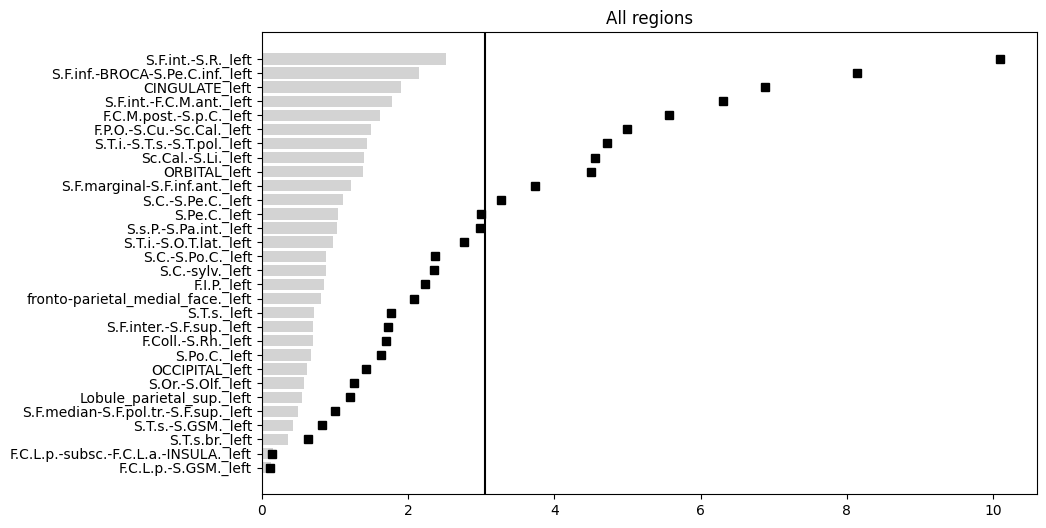

In [33]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

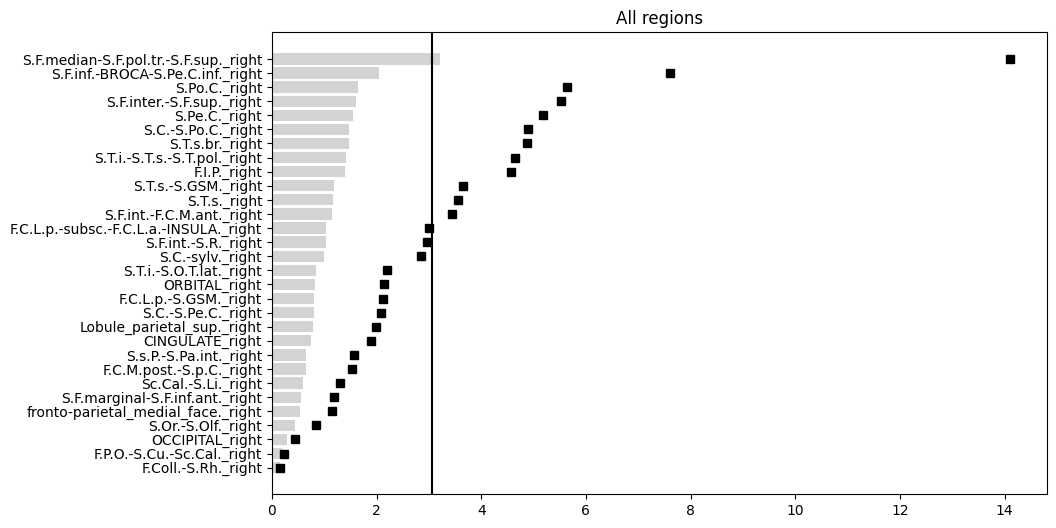

In [34]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [35]:
# df.to_csv(output_filename)

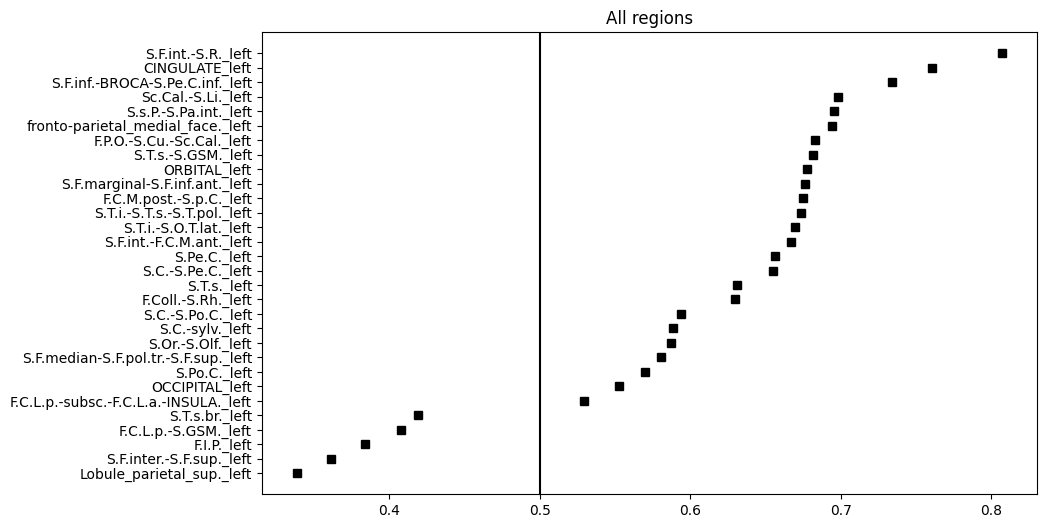

In [36]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal_auc(df_auc[df_auc.side=='left'], "region", ax, "auc", "auc", "auc",  True, "All regions")
plt.show()

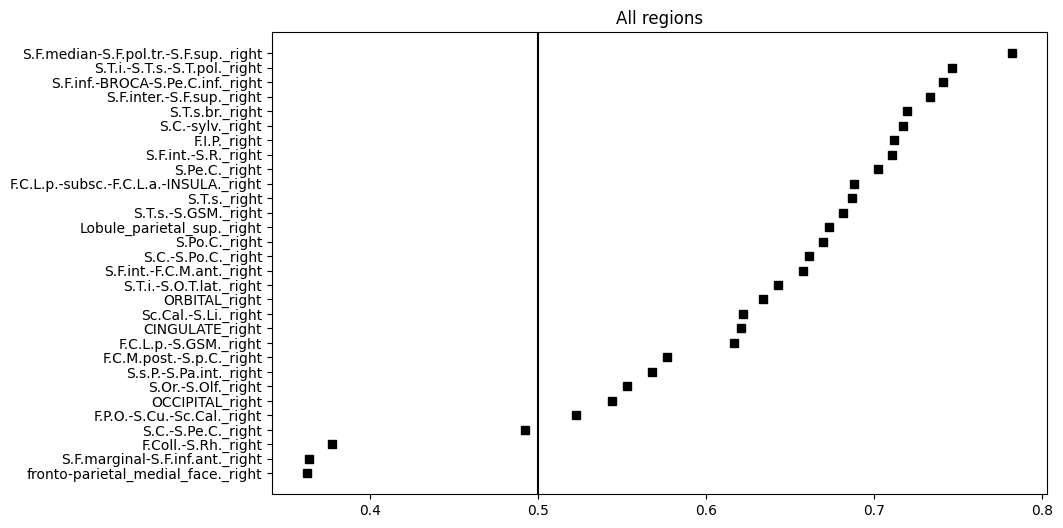

In [37]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal_auc(df_auc[df_auc.side=='right'], "region", ax, "auc", "auc", "auc",  True, "All regions")
plt.show()